# <span style="color:darkorange"> Exercises 04 (NSL) </span>
# <span style="color:darkorange"> 04.1: MD_MC code extension - pressure estimation </span>

To estimate <font color="darkorange">pressure $P$</font>, with its block averages, progressive average values and progresssive uncertainties, the <font color="darkorange">virial theorem</font> was exploited. The pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

which, in <font color="darkorange">reduced Lennard-Jones units</font> ($\sigma$ for length, $\epsilon$ for energy, $m$ for mass), becomes:

$$ \begin {align*}
P &= (\rho\sigma^3)\frac{1}{\sigma^3}(k_BT/\epsilon)\epsilon  + \frac{1}{3V/\sigma^3}\frac{1}{\sigma^3} \left\langle \sum_{i=1}^{N-1} \sum_{j>i}^N 48\epsilon \left[ \left(\frac{1}{\left|\vec{r}_i/\sigma -\vec{r}_j/\sigma\right|}\right)^{12} - 
\frac{1}{2} \left(\frac{1}{\left|\vec{r}_i/\sigma -\vec{r}_j/\sigma\right|}\right)^6 \right] \right\rangle \\
  &= \left\{ \rho^\star T^\star + \frac{1}{3V^\star} \left\langle \sum_{i=1}^{N-1} \sum_{j>i}^N 48\left[ \frac{1}{\left|\vec{r^\star}_i -\vec{r^\star}_j\right|^{12}} - 
\frac{1}{2} \frac{1}{\left|\vec{r^\star}_i -\vec{r^\star}_j\right|^6} \right] \right\rangle \right\} \frac{\epsilon}{\sigma^3}
\end{align*}
$$
 
and beacuse the reduced pressure $P^\star$ is expressed in units of $\epsilon/\sigma^3$

$$ P^\star= \rho^\star T^\star + \frac{16}{V^\star} \left\langle \sum_{i=1}^{N-1} \sum_{j>i}^N \left[ \frac{1}{\left|\vec{r^\star}_i -\vec{r^\star}_j\right|^{12}} - 
\frac{1}{2} \frac{1}{\left|\vec{r^\star}_i -\vec{r^\star}_j\right|^6} \right] \right\rangle $$

# <span style="color:darkorange"> 04.2: MD simulations </span>

The code allows <font color="darkorange">performing MD simulations</font> of a system that can be modelled with particles interacting via a Lennard-Jones potential. Such a potential is suited for describing noble gases, like Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu), in the following conditions:


|       phase        |       $\rho^\star$        |    $T^\star$     |     $r_{cut-off}$    |
| ---------------: | :------------------- | :------------------- | :------------------- |
| solid | $1.1$ | $0.8$ | $2.2$ |
| liquid | $0.8$ | $1.1$ | $2.5$ |
| gas | $0.05$ | $1.2$ | $5.0$ |

## The problem of equilibration:

During the <font color="darkorange">first time steps</font> of the simulation, starting from a perfect crystalline configuration, $T$ and the other <font color="darkorange">observables will oscillate</font>: only after some equilibration time will it make sense to take measurements. In other words, like in an actual experiment, the system should be examined only after the <font color="darkorange">suppression of the initial transient</font>.


To take the system to a stationary condition, many initial parameters were tried out (`ReadInput >> restart = 0` must be used) and the <font color="darkorange">best suited for stabilizing</font> on the desired $T^\star$ (dashed, gray horizontal lines) were:

|       phase        |       $\#$ of blocks     |     $\#$ of steps in a block    |   initial $T^\star$     |
| ---------------: | :------------------- | :------------------- | :------------------- |
| solid | $1000$ | $1$ | $1.55$ |
| liquid | $3000$ | $1$ | $1.975$ |
| gas | $20000$ | $1$ | $0.975$ |

where the choice of having blocks of dimension $1$ stands for probing <font color="darkorange">istantaneous values</font> of the observables, useful for the identification of stability.

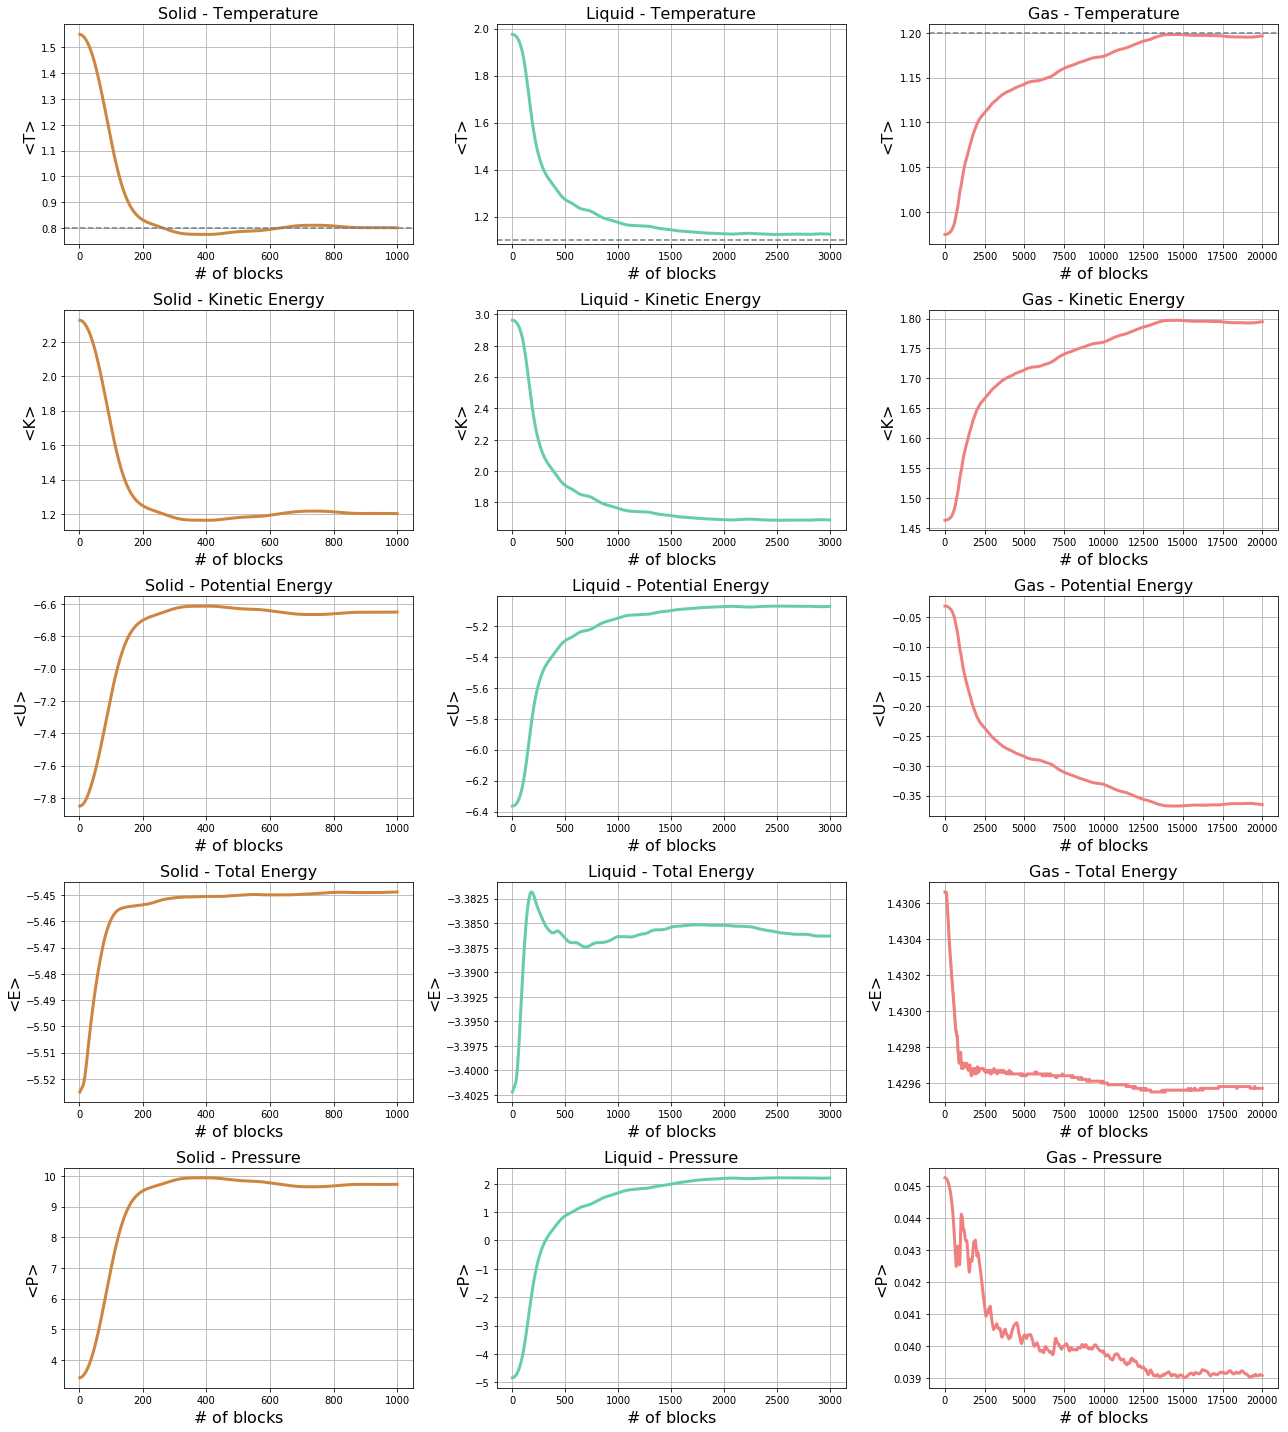

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to read data from file
def read_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip():  # ignore empty lines
                cols = line.split()
                data.append([float(cols[0]), float(cols[2]), float(cols[3])])
    return data

# Define a function to process data
def process_data(data):
    x = [row[0] for row in data[1:]]  # Exclude the first data point
    y = [row[1] for row in data[1:]]
    return x, y

# Function to create subplots
def create_subplot(ax, x, y, color, ylabel, title, phase):
    ax.plot(x, y, color=color, linewidth='3') # Enlarge line size
    ax.set_xlabel('$\#$ of blocks', fontsize=16)  # Enlarge font size
    ax.set_ylabel(ylabel, fontsize=16)  
    ax.set_title(title, fontsize=16)  
    ax.grid(True)
    if ylabel == '<T>':
        if phase == 'solid':
            ax.axhline(y=0.8, color='slategray', linestyle='--')
        elif phase == 'liquid':
            ax.axhline(y=1.1, color='slategray', linestyle='--')
        elif phase == 'gas':
            ax.axhline(y=1.2, color='slategray', linestyle='--')

# Create figure and axes
fig, axs = plt.subplots(5, 3, figsize=(18, 20))

# Read and plot data for each phase
colors = ['peru', 'mediumaquamarine', 'lightcoral']
labels = ['<T>', '<K>', '<U>', '<E>', '<P>']
for i, phase in enumerate(['solid', 'liquid', 'gas']):
    data_temp = read_data(f'./MD_MC_{phase}/thermalization/output_temp_{phase}.dat')
    data_ekin = read_data(f'./MD_MC_{phase}/thermalization/output_ekin_{phase}.dat')
    data_epot = read_data(f'./MD_MC_{phase}/thermalization/output_epot_{phase}.dat')
    data_etot = read_data(f'./MD_MC_{phase}/thermalization/output_etot_{phase}.dat')
    data_pres = read_data(f'./MD_MC_{phase}/thermalization/output_pres_{phase}.dat')

    x_temp, y_temp = process_data(data_temp)
    x_ekin, y_ekin = process_data(data_ekin)
    x_epot, y_epot = process_data(data_epot)
    x_etot, y_etot = process_data(data_etot)
    x_pres, y_pres = process_data(data_pres)

    create_subplot(axs[0, i], x_temp, y_temp, colors[i], labels[0], f'{phase.capitalize()} - Temperature', phase)
    create_subplot(axs[1, i], x_ekin, y_ekin, colors[i], labels[1], f'{phase.capitalize()} - Kinetic Energy', phase)
    create_subplot(axs[2, i], x_epot, y_epot, colors[i], labels[2], f'{phase.capitalize()} - Potential Energy', phase)
    create_subplot(axs[3, i], x_etot, y_etot, colors[i], labels[3], f'{phase.capitalize()} - Total Energy', phase)
    create_subplot(axs[4, i], x_pres, y_pres, colors[i], labels[4], f'{phase.capitalize()} - Pressure', phase)

# Adjust layout
plt.tight_layout()
plt.show()

## Tendencies during thermalizaion: a physical insight

The <font color="darkorange">solid</font> and the <font color="darkorange">liquid</font> initially <font color="darkorange">cool down</font>: the particles start positioned in a very coordinated manner, so, as soon as they displace, the potential energy $U$ rises, thus the kinetic energy (and $T$ as well) must decrease to <font color="darkorange">conserve energy</font>. 

The <font color="darkorange">gas</font>, instead, <font color="darkorange">warms up</font>. This behaviour corresponds to the tendency of a system to explore the states that <font color="darkorange">maximize entropy</font>. During motion, collisions take place and potential energy is converted into kinetic energy, leading to a raise in temperature and a more disordered state.

## Proper simulation:

After thermalization, the system is studied with a simulation of 40 blocks of 2000 steps each. The key point is to <font color="darkorange">restart</font> (`ReadInput >> restart = 1`) the simulation <font color="darkorange">from the equlibrium configuration</font>, priorly saved in `config.out` and `velocity.out`.

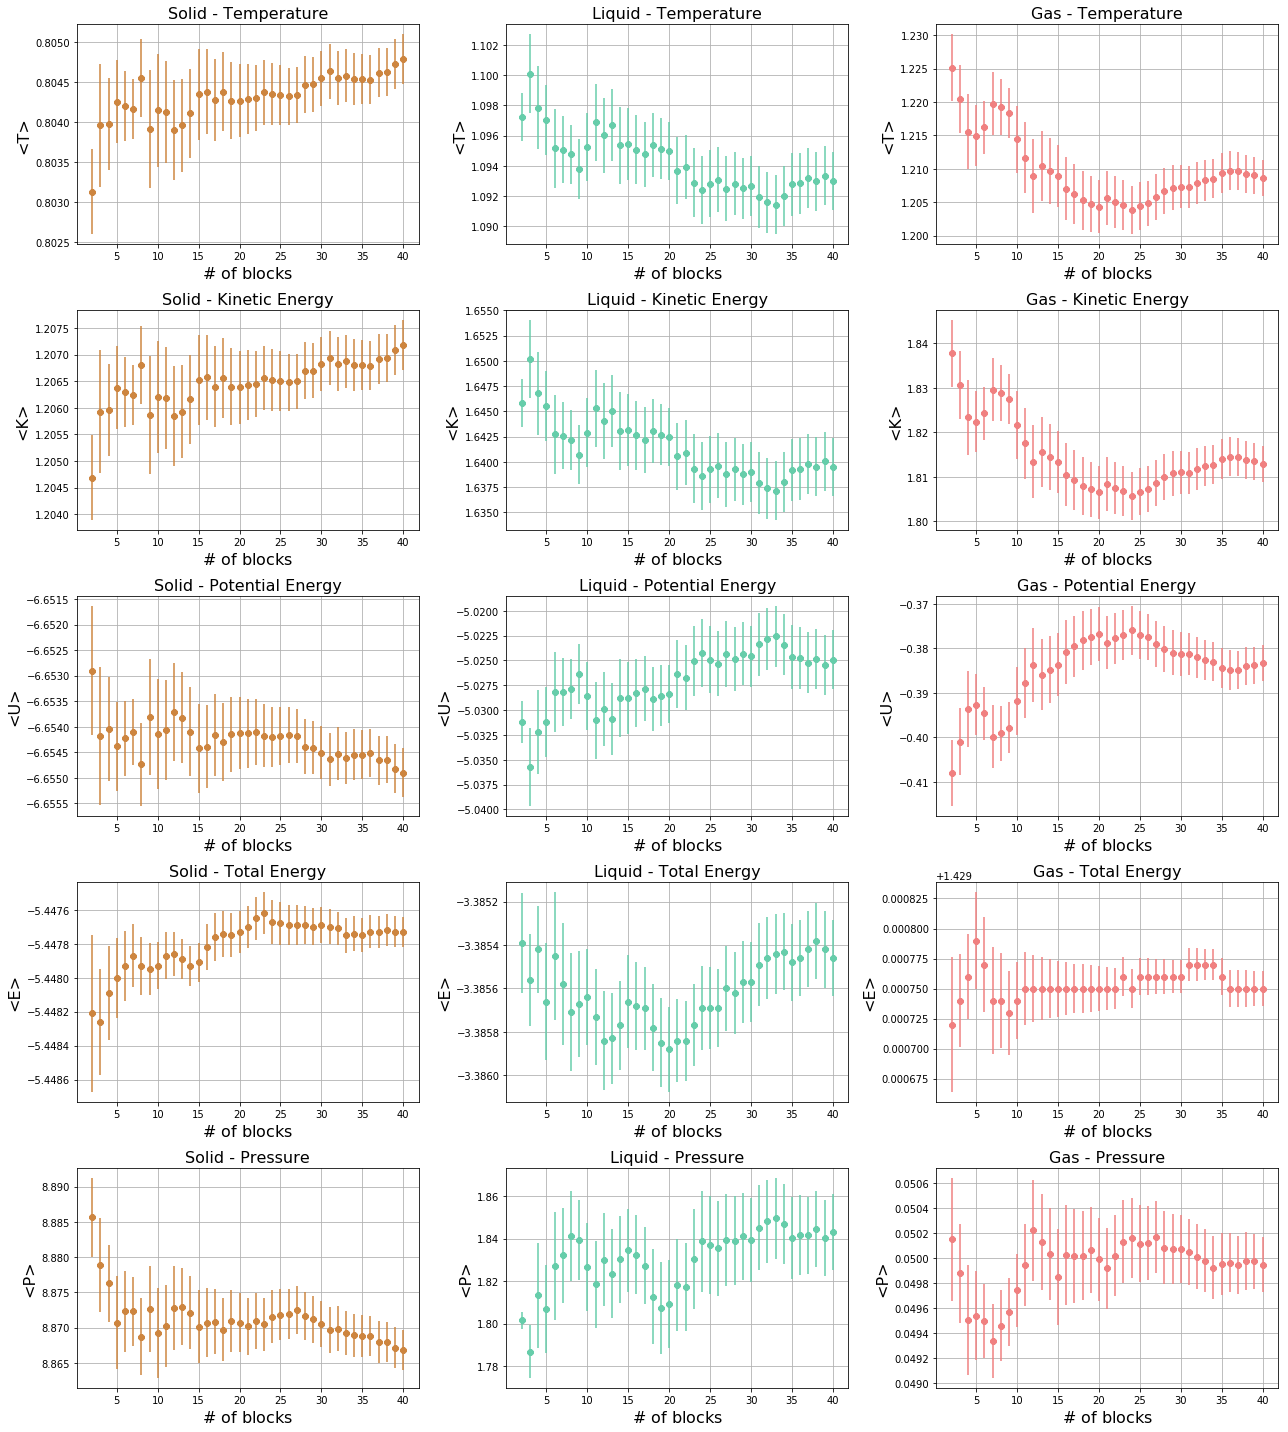

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to read data from file
def read_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip():  # ignore empty lines
                cols = line.split()
                data.append([float(cols[0]), float(cols[2]), float(cols[3])])
    return data

# Define a function to process data
def process_data(data):
    x = [row[0] for row in data[1:]]  # Exclude the first data point
    y = [row[1] for row in data[1:]]
    y_err = [row[2] for row in data[1:]]
    return x, y, y_err

# Function to create subplots
def create_subplot(ax, x, y, y_err, color, ylabel, title):
    ax.errorbar(x, y, yerr=y_err, color=color, fmt='8', ecolor=color)
    ax.set_xlabel('$\#$ of blocks', fontsize=16) 
    ax.set_ylabel(ylabel, fontsize=16)  
    ax.set_title(title, fontsize=16)  
    ax.grid(True)

# Create figure and axes
fig, axs = plt.subplots(5, 3, figsize=(18, 20))

# Read and plot data for each phase
colors = ['peru', 'mediumaquamarine', 'lightcoral']
labels = ['<T>', '<K>', '<U>', '<E>', '<P>']
for i, phase in enumerate(['solid', 'liquid', 'gas']):
    data_temp = read_data(f'./MD_MC_{phase}/output_temp_{phase}.dat')
    data_ekin = read_data(f'./MD_MC_{phase}/output_ekin_{phase}.dat')
    data_epot = read_data(f'./MD_MC_{phase}/output_epot_{phase}.dat')
    data_etot = read_data(f'./MD_MC_{phase}/output_etot_{phase}.dat')
    data_pres = read_data(f'./MD_MC_{phase}/output_pres_{phase}.dat')

    x_temp, y_temp, y_err_temp = process_data(data_temp)
    x_ekin, y_ekin, y_err_ekin = process_data(data_ekin)
    x_epot, y_epot, y_err_epot = process_data(data_epot)
    x_etot, y_etot, y_err_etot = process_data(data_etot)
    x_pres, y_pres, y_err_pres = process_data(data_pres)

    create_subplot(axs[0, i], x_temp, y_temp, y_err_temp, colors[i], labels[0], f'{phase.capitalize()} - Temperature')
    create_subplot(axs[1, i], x_ekin, y_ekin, y_err_ekin, colors[i], labels[1], f'{phase.capitalize()} - Kinetic Energy')
    create_subplot(axs[2, i], x_epot, y_epot, y_err_epot, colors[i], labels[2], f'{phase.capitalize()} - Potential Energy')
    create_subplot(axs[3, i], x_etot, y_etot, y_err_etot, colors[i], labels[3], f'{phase.capitalize()} - Total Energy')
    create_subplot(axs[4, i], x_pres, y_pres, y_err_pres, colors[i], labels[4], f'{phase.capitalize()} - Pressure')

# Adjust layout
plt.tight_layout()
plt.show()
